This notebook includes functions for plotting the figures reported in the paper.

In [1]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [2]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [3]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [4]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [5]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [9]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/experiments/10172023_v3.0_exps


In [10]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/10172023_v3.0/results"

# Directory to save figures
PLOT_DIR = "figures"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [11]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [15]:
folders = ["baseline_5runs"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.33328222265775054]
values [0.31744673246323374]
values [0.3212506871718563]
values [0.3441323691579558]
values [0.3714055504935358]
Overall quality when there is no bots: 0.34


# Shuffle 
Effects of network structure on Quality

In [21]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,3.838520e-01,3.144169e-01,2.972853e-01,3.013494e-01,3.246926e-01,all_shuffle__None2.json,all
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,2.978962e-01,3.202467e-01,3.301699e-01,3.095196e-01,2.738813e-01,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,9.881313e-324,9.881313e-324,9.881313e-324,9.881313e-324,9.881313e-324,community_shuffle__None2.json,community


In [22]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [23]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
54,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.32609,0.345889,0.318161,0.307571,0.320501,None


In [24]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,3.838520e-01,3.144169e-01,2.972853e-01,3.013494e-01,3.246926e-01,all_shuffle__None2.json,all
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,2.978962e-01,3.202467e-01,3.301699e-01,3.095196e-01,2.738813e-01,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,9.881313e-324,9.881313e-324,9.881313e-324,9.881313e-324,9.881313e-324,community_shuffle__None2.json,community


In [25]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [26]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,3.260903e-01,...,3.075705e-01,3.205005e-01,None,NaN,9.661834e-01,1.024844e+00,9.426893e-01,9.113106e-01,9.496214e-01,0
1,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,3.838520e-01,...,3.013494e-01,3.246926e-01,all,all_shuffle__None2.json,1.137327e+00,9.315960e-01,8.808362e-01,8.928777e-01,9.620421e-01,1
2,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,2.978962e-01,...,3.095196e-01,2.738813e-01,hub,hub_shuffle__None2.json,8.826461e-01,9.488692e-01,9.782709e-01,9.170856e-01,8.114916e-01,2
3,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,9.881313e-324,...,9.881313e-324,9.881313e-324,community,community_shuffle__None2.json,2.964394e-323,2.964394e-323,2.964394e-323,2.964394e-323,2.964394e-323,3


In [27]:
results

,id,run_no,beta,quality_0,quality_1,quality_4,rho,gamma,shuffle,mu,file_name,quality_2,phi,epsilon,targeting_criterion,quality_3,theta,graph_gml,relative_quality_
0,0,0,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.661834e-01
1,1,0,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,1.137327e+00
2,2,0,0.05,2.978962e-01,3.202467e-01,2.738813e-01,0.8,0.01,hub,0.5,hub_shuffle__None2.json,3.301699e-01,0.0,0.0001,none,3.095196e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,8.826461e-01
3,3,0,0.05,9.881313e-324,9.881313e-324,9.881313e-324,0.8,0.01,community,0.5,community_shuffle__None2.json,9.881313e-324,0.0,0.0001,none,9.881313e-324,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,2.964394e-323
4,0,1,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,1.024844e+00
5,1,1,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.315960e-01
6,2,1,0.05,2.978962e-01,3.202467e-01,2.738813e-01,0.8,0.01,hub,0.5,hub_shuffle__None2.json,3.301699e-01,0.0,0.0001,none,3.095196e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.488692e-01
7,3,1,0.05,9.881313e-324,9.881313e-324,9.881313e-324,0.8,0.01,community,0.5,community_shuffle__None2.json,9.881313e-324,0.0,0.0001,none,9.881313e-324,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,2.964394e-323
8,0,2,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.426893e-01
9,1,2,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,8.808362e-01


Plot data for default values $\gamma=0.01$

In [28]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,beta,quality_0,quality_1,quality_4,rho,gamma,shuffle,mu,file_name,quality_2,phi,epsilon,targeting_criterion,quality_3,theta,graph_gml,relative_quality_
0,0,0,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.661834e-01
1,1,0,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,1.137327e+00
2,2,0,0.05,2.978962e-01,3.202467e-01,2.738813e-01,0.8,0.01,hub,0.5,hub_shuffle__None2.json,3.301699e-01,0.0,0.0001,none,3.095196e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,8.826461e-01
3,3,0,0.05,9.881313e-324,9.881313e-324,9.881313e-324,0.8,0.01,community,0.5,community_shuffle__None2.json,9.881313e-324,0.0,0.0001,none,9.881313e-324,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,2.964394e-323
4,0,1,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,1.024844e+00


In [29]:
# !pip install statannotations

In [30]:
plot_data

,id,run_no,beta,quality_0,quality_1,quality_4,rho,gamma,shuffle,mu,file_name,quality_2,phi,epsilon,targeting_criterion,quality_3,theta,graph_gml,relative_quality_
0,0,0,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.661834e-01
1,1,0,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,1.137327e+00
2,2,0,0.05,2.978962e-01,3.202467e-01,2.738813e-01,0.8,0.01,hub,0.5,hub_shuffle__None2.json,3.301699e-01,0.0,0.0001,none,3.095196e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,8.826461e-01
3,3,0,0.05,9.881313e-324,9.881313e-324,9.881313e-324,0.8,0.01,community,0.5,community_shuffle__None2.json,9.881313e-324,0.0,0.0001,none,9.881313e-324,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,2.964394e-323
4,0,1,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,1.024844e+00
5,1,1,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.315960e-01
6,2,1,0.05,2.978962e-01,3.202467e-01,2.738813e-01,0.8,0.01,hub,0.5,hub_shuffle__None2.json,3.301699e-01,0.0,0.0001,none,3.095196e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.488692e-01
7,3,1,0.05,9.881313e-324,9.881313e-324,9.881313e-324,0.8,0.01,community,0.5,community_shuffle__None2.json,9.881313e-324,0.0,0.0001,none,9.881313e-324,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,2.964394e-323
8,0,2,0.05,3.260903e-01,3.458886e-01,3.205005e-01,0.8,0.01,None,0.5,NaN,3.181609e-01,0.0,0.0001,none,3.075705e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,9.426893e-01
9,1,2,0.05,3.838520e-01,3.144169e-01,3.246926e-01,0.8,0.01,all,0.5,all_shuffle__None2.json,2.972853e-01,0.0,0.0001,none,3.013494e-01,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,8.808362e-01


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:8.708e-07 t=-5.120e+01
hubs vs. communities: Welch's t-test independent samples, P_val:6.083e-06 t=3.146e+01
random vs. hubs: Welch's t-test independent samples, P_val:3.634e-01 t=9.751e-01
random vs. hubs+communities: Welch's t-test independent samples, P_val:9.695e-01 t=4.011e-02


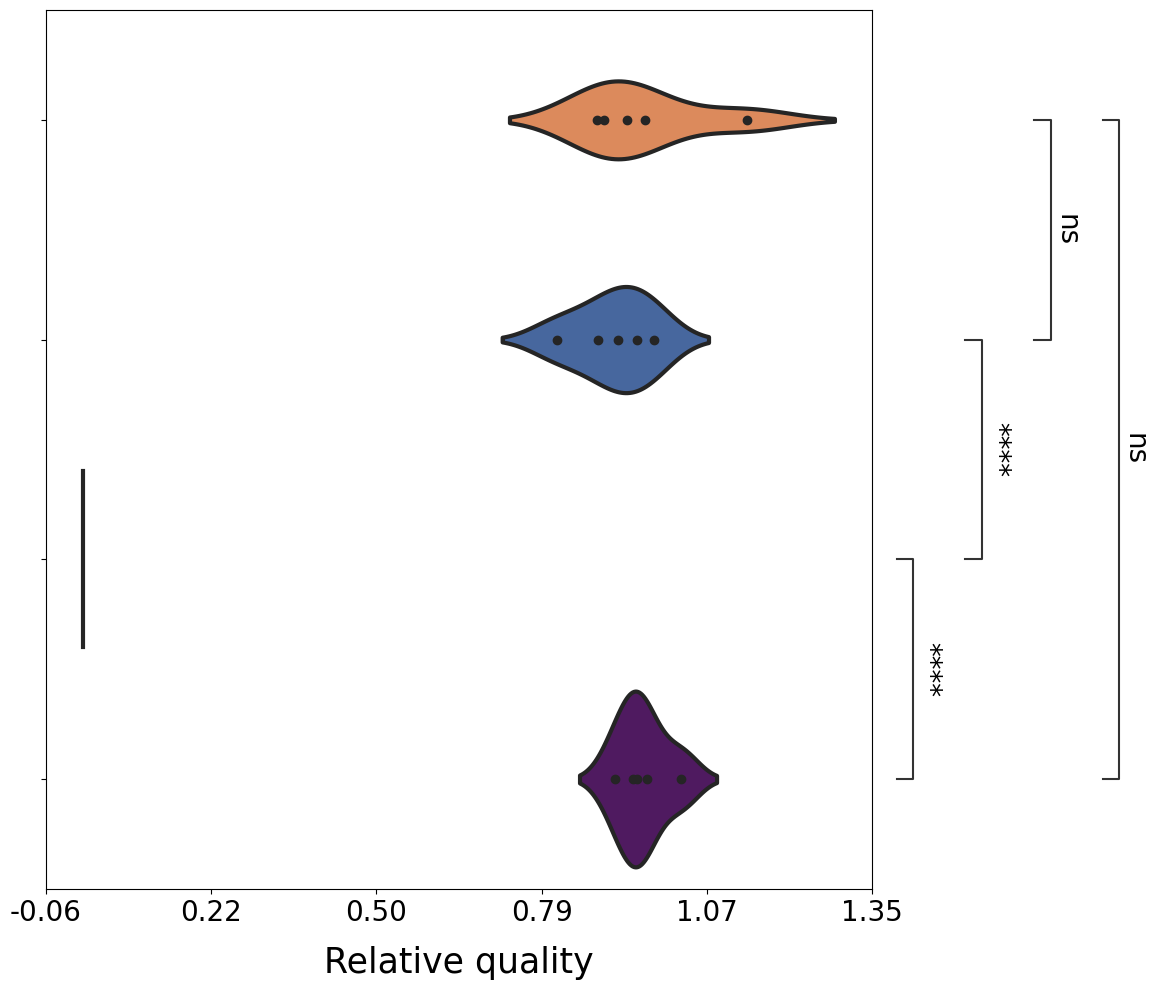

In [31]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
# patch_violinplot(ax, palette=BLUEPALETTE, n=4)
# point_violinplot(ax, palette=BLUEPALETTE, n=4)
# sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [33]:
folders = ["vary_alpha_10runs"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,beta,rho,gamma,alpha,mu,relative_quality_0,relative_quality_4,relative_quality_2,relative_quality_1,phi,epsilon,targeting_criterion,relative_quality_3,theta,graph_gml,quality_
13,5,1,0,0.8,0,1,0.5,0.653073,0.950479,0.784998,0.73355,0,0.0001,none,0.785245,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.247576
5,5,0,0,0.8,0,1,0.5,0.653073,0.950479,0.784998,0.73355,0,0.0001,none,0.785245,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.220414
21,5,2,0,0.8,0,1,0.5,0.653073,0.950479,0.784998,0.73355,0,0.0001,none,0.785245,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.264940
37,5,4,0,0.8,0,1,0.5,0.653073,0.950479,0.784998,0.73355,0,0.0001,none,0.785245,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.320790
29,5,3,0,0.8,0,1,0.5,0.653073,0.950479,0.784998,0.73355,0,0.0001,none,0.785245,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.265023


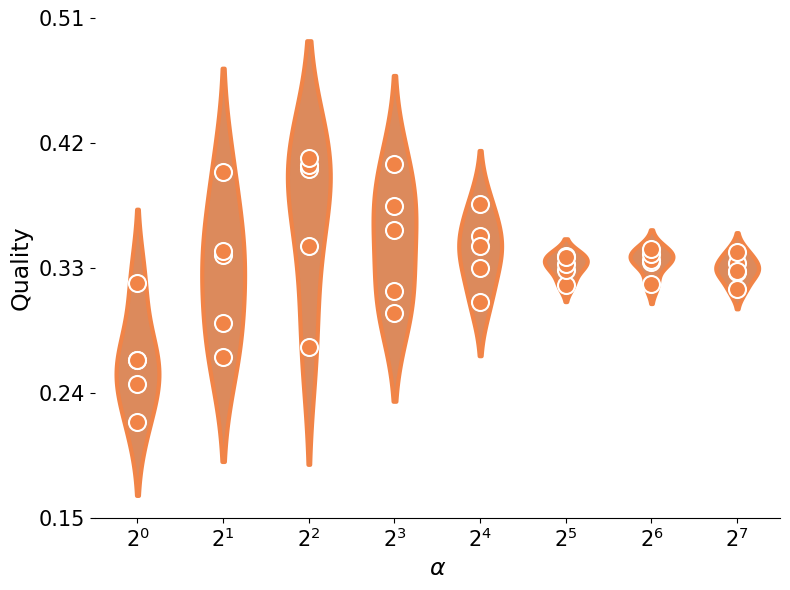

In [34]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [30]:
RES_DIR

'results'

In [35]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,beta,rho,gamma,alpha,mu,phi,epsilon,targeting_criterion,theta,graph_gml,quality_
3,3,0,0,0.8,0,15,0.1,0,0.0001,none,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.321312
8,3,1,0,0.8,0,15,0.1,0,0.0001,none,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.348620
18,3,3,0,0.8,0,15,0.1,0,0.0001,none,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.320538
23,3,4,0,0.8,0,15,0.1,0,0.0001,none,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.350397
13,3,2,0,0.8,0,15,0.1,0,0.0001,none,1,/N/u/baotruon/BigRed200/simsom/experiments/101...,0.344115


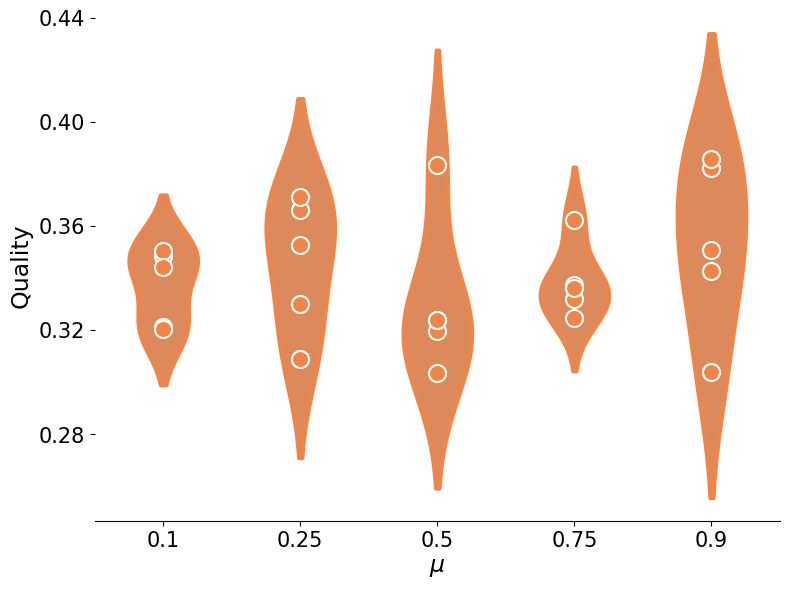

In [36]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [52]:
data = read_data(
    RES_DIR, folders=["vary_thetaphi_5runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

In [53]:
thetaphi

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,2,0.05,0.01,0.5,0.0001,0.4,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.294861,0.316336,0.307431,0.335226,0.271720,15
1,32,0.05,0.01,0.5,0.0001,1.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.320955,0.342596,0.375685,0.250569,0.310238,15
2,32,0.05,0.01,0.5,0.0001,0.9,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.405872,0.286383,0.239456,0.217496,0.268283,15
3,4,0.05,0.01,0.5,0.0001,0.1,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.395690,0.327554,0.389005,0.342995,0.263848,15
4,8,0.05,0.01,0.5,0.0001,0.2,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.305218,0.329937,0.354628,0.394077,0.365678,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.340422,0.338168,0.283056,0.352099,0.344653,15
73,16,0.05,0.01,0.5,0.0001,0.2,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.189506,0.219395,0.333485,0.259067,0.357813,15
74,4,0.05,0.01,0.5,0.0001,1.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.311792,0.302658,0.235217,0.339693,0.375654,15
75,1,0.05,0.01,0.5,0.0001,0.5,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.312150,0.331106,0.319569,0.339490,0.297274,15


### Phigamma

In [54]:
data = read_data(
    RES_DIR, folders=["vary_phigamma_5runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

### Thetagamma

In [55]:
data = read_data(RES_DIR, folders=["vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

## Single param plots
Subset data (only plot default values for each panel)

In [56]:
phigamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,1,0.05,0.0010,0.5,0.0001,0.2,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.329965,0.321970,0.361159,0.288719,0.333825,15
1,1,0.05,0.0100,0.5,0.0001,0.3,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.309601,0.330064,0.351665,0.311120,0.349100,15
2,1,0.05,0.0010,0.5,0.0001,0.5,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.332013,0.352189,0.348362,0.354788,0.328328,15
3,1,0.05,0.0001,0.5,0.0001,0.9,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.289406,0.321949,0.350164,0.332603,0.301815,15
4,1,0.05,0.0010,0.5,0.0001,0.8,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.312028,0.384380,0.313134,0.397265,0.324811,15
5,1,0.05,0.1000,0.5,0.0001,0.4,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.193942,0.276883,0.170006,0.282986,0.270864,15
6,1,0.05,0.0010,0.5,0.0001,0.4,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.331395,0.333614,0.359757,0.308291,0.311623,15
7,1,0.05,0.0100,0.5,0.0001,0.7,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.318964,0.352808,0.297159,0.366011,0.292157,15
8,1,0.05,0.0001,0.5,0.0001,0.3,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.320380,0.307994,0.321563,0.349371,0.327798,15
9,1,0.05,0.0010,0.5,0.0001,0.7,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.332781,0.314300,0.375202,0.332013,0.296417,15


In [57]:
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,epsilon_y,rho_y,graph_gml_y,targeting_criterion_y,quality_0_y,quality_1_y,quality_2_y,quality_3_y,quality_4_y,alpha_y
0,1,0.05,0.01,0.5,0.0001,0.1,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.303797,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.319000,0.329629,0.291147,0.307387,0.276253,15
1,1,0.05,0.01,0.5,0.0001,0.4,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.330293,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.312821,0.320566,0.320753,0.320120,0.335459,15
2,1,0.05,0.01,0.5,0.0001,0.8,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.377970,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.312006,0.294770,0.357234,0.330645,0.294390,15
3,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.326090,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.371731,0.350271,0.328451,0.309070,0.348040,15
4,1,0.05,0.01,0.5,0.0001,1.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.324535,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.305274,0.350459,0.326135,0.314931,0.335468,15
5,1,0.05,0.01,0.5,0.0001,0.6,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.313231,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.339442,0.309588,0.341276,0.293173,0.362465,15
6,1,0.05,0.01,0.5,0.0001,0.3,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.348426,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.309601,0.330064,0.351665,0.311120,0.349100,15
7,1,0.05,0.01,0.5,0.0001,0.7,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.301536,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.318964,0.352808,0.297159,0.366011,0.292157,15
8,1,0.05,0.01,0.5,0.0001,0.2,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.289534,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.296484,0.295328,0.329641,0.302740,0.345030,15
9,1,0.05,0.01,0.5,0.0001,0.5,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.312150,...,0.0001,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.329782,0.337453,0.346805,0.282914,0.300477,15


In [58]:
# VARYING GAMMA
vary_gamma = pd.merge(
    phigamma[phigamma.phi == 0],
    thetagamma[thetagamma.theta == 1],
    on=["theta", "beta", "gamma", "phi"],
)
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
# x = [0.1 * i for i in vary_phi["phi"]]
x = vary_phi["phi"].values
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = pd.merge(
    thetaphi[thetaphi.phi == 0],
    thetagamma[thetagamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [1.0125469224749568, 1.0550031236879889, 0.9704416453942482, 1.0296624976371127, 0.9522766233886173, 0.95048950455813, 0.8819451720220955, 1.0414602911673865, 0.9275020987859413, 0.9446342460509205]
values [0.8699741585613318, 1.069270644901956, 0.8897116486834107, 0.8930352860067519, 1.0054104635046794, 0.873394696496379, 0.9925109042141979, 1.0229068612731727, 1.0544053669771907, 0.9247470121709814]
values [1.0585604031394487, 0.6590974534460944, 0.6334260291671758, 0.8085271112976953, 0.9638423273161753, 1.0359399667488127, 0.5255058592019154, 0.5125502247794669, 0.8830324887042152, 0.6029784206165223]
values [1.1014147678762338, 1.0378287347260828, 0.9731777661787833, 0.9157547800400618, 1.031218023233295, 1.0786717151100966, 1.1006291602934781, 0.945716612412138, 0.9757398221895527, 1.0086670723479165]
values [0.9001298408243169, 0.9777360536167053, 0.8538276351046975, 1.008450733654294, 1.0651002430689016, 0.9451767060394115, 0.976668330918668, 0.8626500003934574, 0.910766

In [59]:
vary_gamma

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,relative_quality_3,relative_quality_4,relative_quality_5,relative_quality_6,relative_quality_7,relative_quality_8,relative_quality_9,mean_relative_quality,std_relative_quality,ci_relative_quality
0,1,0.05,0.0010,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.341738,...,1.029662,0.952277,0.950490,0.881945,1.041460,0.927502,0.944634,0.976596,0.055941,0.040018
1,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.293619,...,0.893035,1.005410,0.873395,0.992511,1.022907,1.054405,0.924747,0.959537,0.077602,0.055513
2,1,0.05,0.1000,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.357268,...,0.808527,0.963842,1.035940,0.525506,0.512550,0.883032,0.602978,0.768346,0.208355,0.149048
3,1,0.05,0.0100,0.5,0.0001,0.0,0.8,/N/u/baotruon/BigRed200/simsom/experiments/101...,none,0.371731,...,0.915755,1.031218,1.078672,1.100629,0.945717,0.975740,1.008667,1.016882,0.064621,0.046227


### Plot

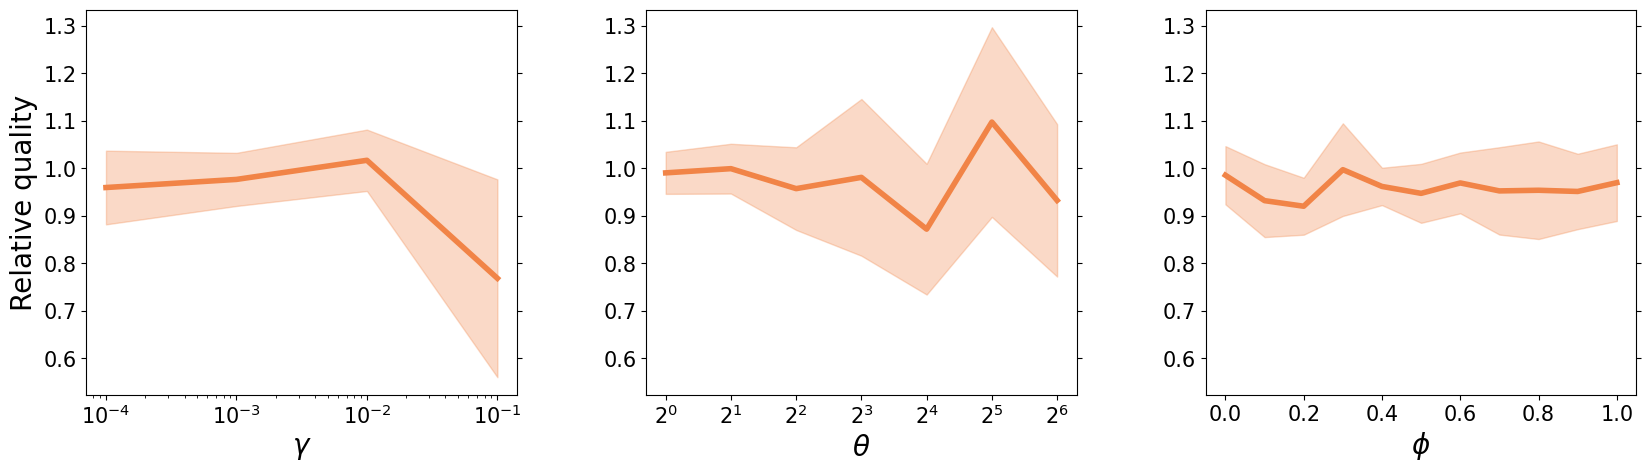

In [60]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [61]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

values [0.8736522514076132, 0.9372819248969068, 0.9108986072395608, 0.9932505045886952, 0.8050875428219059]
values [0.9509665333255444, 1.0150893093918538, 1.1131304737514112, 0.7424189009119863, 0.91921323762243]
values [1.2025708939044117, 0.8485334490505732, 0.7094913857805027, 0.6444258477938146, 0.7949054794415034]
values [1.1724031966033106, 0.9705206535593768, 1.1525960487938662, 1.0162705694479177, 0.7817635686358579]
values [0.9043388939693624, 0.9775794935009443, 1.0507381915014842, 1.1676231955588339, 1.0834779555596665]
values [0.947957586301733, 0.8152380541953576, 1.059500821899618, 0.8270895700648034, 0.8197074719467972]
values [0.8926838944949416, 0.8701299648583518, 1.5759332839737208, 0.9742377582306099, 0.822552398229351]
values [1.2823182125195924, 1.0831014236423608, 0.9893928217127133, 0.6713413401226163, 1.0191745941666914]
values [1.1608361564688279, 1.1398782440021908, 1.197962209034264, 0.6649252110482727, 1.262282309056371]
values [1.0304210403544665, 0.58239

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.958930,0.961049,0.910342,1.015630,0.969711,0.947895,0.962989,0.893431,0.965889,0.895904,0.972225
1,2,0.982745,0.908482,0.943004,0.970620,0.904034,0.946622,0.988771,0.962728,0.996516,0.937024,0.963853
2,4,0.939856,1.018711,1.016011,1.066841,1.060573,0.938121,0.939094,0.879648,0.882960,1.136621,0.927406
3,8,1.086199,0.947032,1.036752,0.902602,0.981241,0.959686,0.946155,1.006787,0.909381,0.871581,0.828447
4,16,0.900642,1.176836,0.805483,0.802373,0.889511,0.945224,0.898968,0.749941,1.085177,0.989777,0.959065


In [62]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

(7, 11)

### Data: Thetagamma matrix

In [63]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

values [1.036689652760201, 1.088281321122662, 0.9208699751669344, 1.0590202870407242, 0.9195582558421274]
values [0.7699789136060395, 0.7935050035006519, 0.9550764407213078, 0.7096915256690804, 1.149963151666231]
values [1.2810697990575715, 1.0899347426220776, 0.7675063106501959, 1.3281176714893737, 0.9787221322948584]
values [0.6779529697633536, 0.5636975000135366, 0.7802394855321912, 0.7471609176040003, 0.42954710279578334]
values [1.0655074678918786, 1.2171531224400975, 1.2899137302784711, 0.9814736330908164, 0.7867168189958451]
values [0.7431846767967272, 0.7630406408645709, 1.1440990292803719, 0.8499327666301383, 1.01827102185394]
values [1.2907404140405014, 0.7611607579176606, 1.1478405408424015, 1.1581640031572225, 1.2148412064894698]
values [0.7799630458012485, 1.0721643494259387, 0.9160503149783351, 1.287806735957586, 0.752706495225158]
values [1.488877964484832, 0.7275321429686572, 1.2361468934888447, 0.7740510087041013, 0.7202600739632006]
values [1.0307118601309668, 1.13780

gamma,theta,0.0001,0.001,0.01,0.1
0,1,0.973593,0.949206,1.021885,0.712001
1,2,0.982881,0.969728,1.015770,0.940337
2,4,0.896261,1.004884,0.974520,0.698622
3,8,0.903706,0.997710,0.875643,0.784174
4,16,0.989374,1.068153,0.843041,0.639720


In [64]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [65]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

values [0.9776625167379351, 0.9539753040657044, 1.0700906799584482, 0.8554547576907743, 0.9891003007970246]
values [0.9173265055274864, 0.9779573677736033, 1.0419596288430284, 0.9218266563063199, 1.0343582294966738]
values [0.9837310649165245, 1.0435124649991685, 1.0321740885470503, 1.0512131431812106, 0.9728124227935135]
values [0.8574915619213657, 0.9539137532289075, 1.0375119125963166, 0.9854806709092683, 0.8942572513491696]
values [0.9245176473267658, 1.1388904720665483, 0.9277952784621819, 1.177068870852978, 0.9623933768065123]
values [0.5746362615084943, 0.8203856554963587, 0.5037150499278884, 0.8384668770186313, 0.80255222216198]
values [0.9818997244822097, 0.9884747076112552, 1.06593476320952, 0.9134444360134331, 0.9233163590358265]
values [0.9450680615907734, 1.0453470010901, 0.8804629095993145, 1.0844649150223555, 0.8656401498327292]
values [0.9492642325775433, 0.9125656697147815, 0.9527690330978322, 1.0351630534979728, 0.9712419448146979]
values [0.9860083114318353, 0.931249

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,0.945480,1.003986,1.011879,0.824691
1,0.1,0.986129,0.941063,0.902756,0.837572
2,0.2,0.940353,0.969257,0.929900,0.782267
3,0.3,0.964201,0.998639,0.978686,0.806378
4,0.4,1.062022,0.974614,0.953898,0.707951


In [66]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

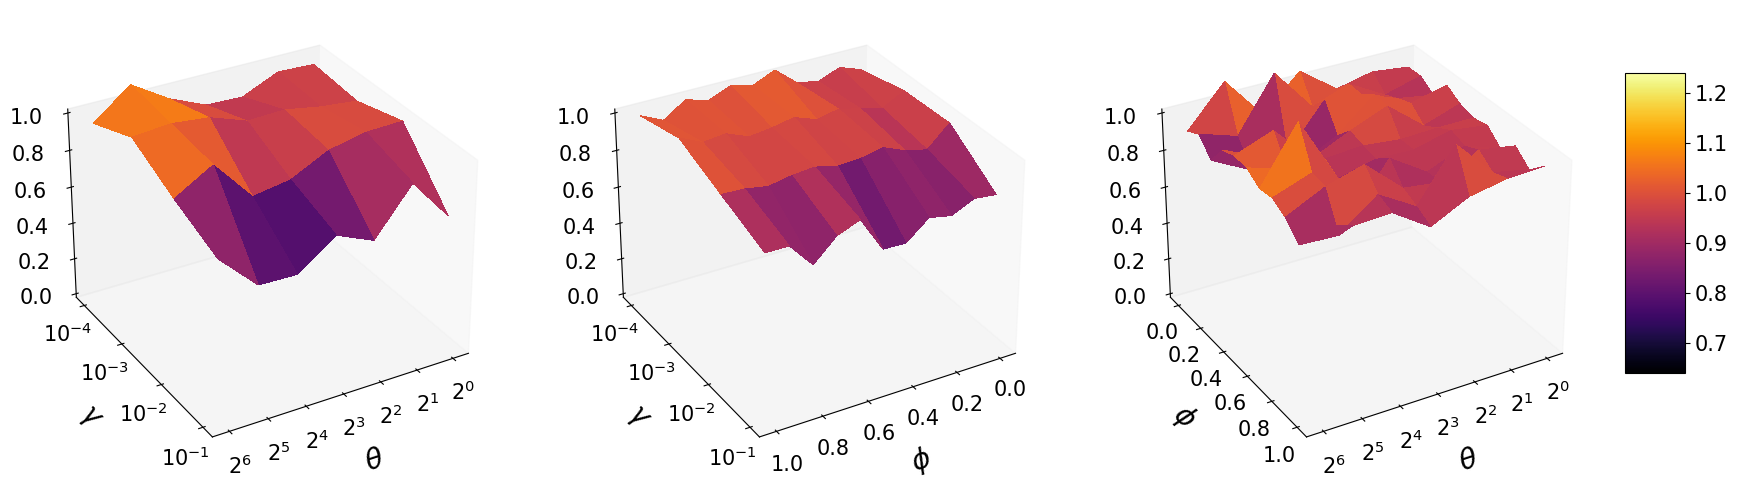

In [67]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [50]:
data = read_data(RES_DIR, folders=["strategies_5runs_"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. partisanship: Welch's t-test independent samples, P_val:1.117e-03 t=8.365e+00
random vs. hubs: Welch's t-test independent samples, P_val:6.451e-01 t=-4.877e-01
random vs. misinformation: Welch's t-test independent samples, P_val:5.496e-01 t=6.274e-01
random vs. liberal: Welch's t-test independent samples, P_val:1.117e-03 t=8.365e+00
random vs. conservative: Welch's t-test independent samples, P_val:1.117e-03 t=8.365e+00


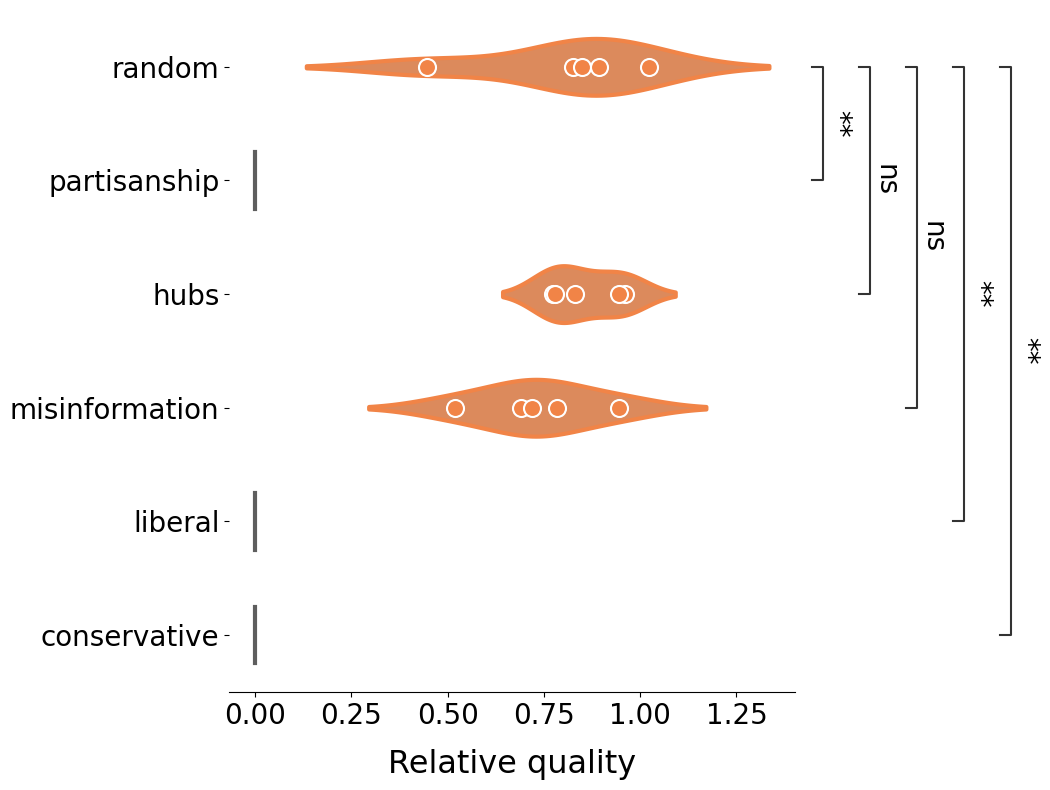

In [68]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()